In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import pymc as pm
import arviz as az


sns.set_style("whitegrid")

In [2]:
df_train = pd.read_csv('train_clf.csv')
df_train

,a,b,c,y
0,6.061051,8.085120,-0.901515,0.0
1,8.625052,9.712480,0.410613,0.0
2,1.705775,0.676360,1.823731,1.0
3,2.170837,1.363792,1.311898,1.0
4,0.467688,1.271315,0.085517,1.0
...,...,...,...,...
95,2.491194,0.685869,3.200508,1.0
96,5.798723,6.416613,0.224369,0.0
97,6.553074,8.428001,-0.687934,0.0
98,1.441131,4.369016,-1.913370,1.0


In [3]:
x_train = df_train.drop('y', axis=1)
y_train = df_train['y']

/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


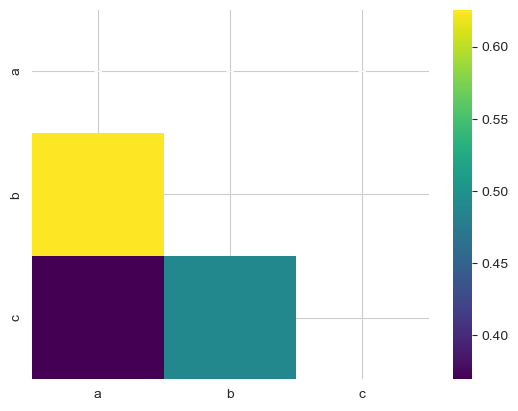

In [4]:
corr = x_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis');

In [5]:
scaler = StandardScaler()
x_train_transformed = scaler.fit_transform(x_train)

In [6]:
y_train.value_counts()

y
1.0    51
0.0    49
Name: count, dtype: int64

In [7]:
NUM_FEATURES = 3

with pm.Model() as model:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=2, shape=NUM_FEATURES)

    x_shared = pm.MutableData('x_shared', x_train_transformed)

    μ = α + pm.math.dot(x_shared, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β[2] - β[0]/β[2] * x_shared[:, 0] - β[1]/β[2] * x_shared[:, 1])

    y = pm.Bernoulli('y', p=θ, observed=y_train)

    trace = pm.sample(3000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 19 seconds.


In [8]:
az.summary(trace, var_names=['α','β'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.342,0.534,-1.340,0.672,0.006,0.005,7412.0,6859.0,1.0
β[0],-3.764,1.380,-6.362,-1.178,0.021,0.015,4251.0,5738.0,1.0
β[1],-3.417,1.393,-6.076,-0.814,0.022,0.015,4178.0,5187.0,1.0
β[2],-0.048,1.067,-2.080,1.935,0.018,0.013,3609.0,5310.0,1.0


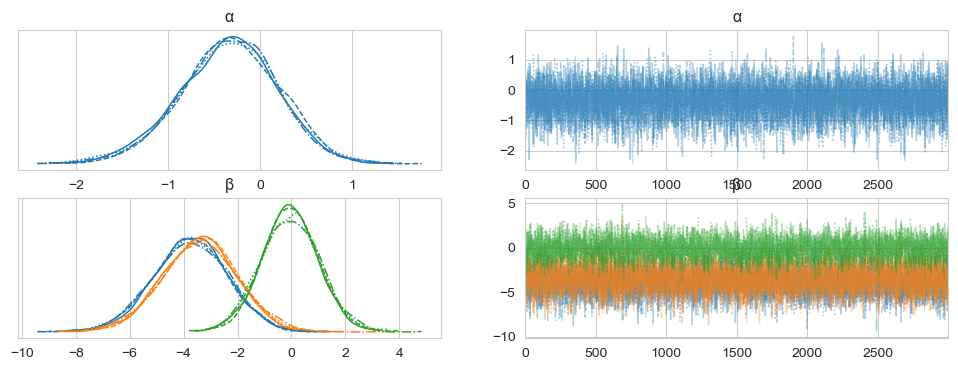

In [9]:
az.plot_trace(trace, var_names=['α','β']);

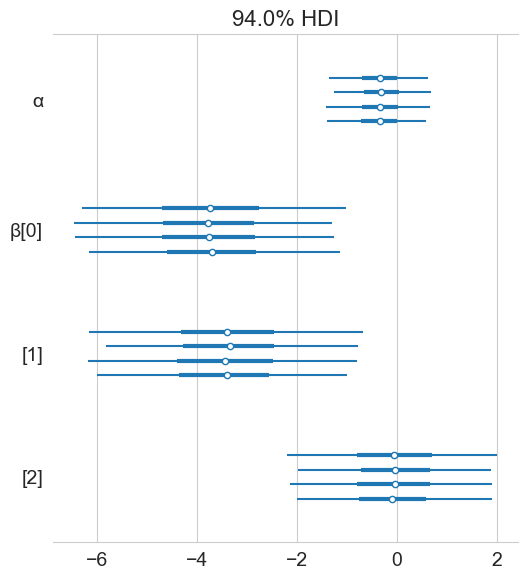

In [10]:
az.plot_forest(trace, var_names=['α','β']);

In [11]:
x_test = pd.read_csv('test_clf.csv')
x_test

,a,b,c
0,6.106970,8.712798,-1.523174
1,5.796587,10.704556,-3.947281
2,6.041652,6.628682,0.602950
3,2.201992,1.272898,1.716670
4,4.501528,3.148547,2.082501
...,...,...,...
95,1.535907,5.895946,-3.239022
96,5.623099,1.351693,4.804637
97,7.483925,3.173440,5.189085
98,9.061999,8.862560,1.132715


In [12]:
x_test_transformed = scaler.transform(x_test)

In [13]:
pm.set_data({"x_shared":x_test_transformed}, model=model)
ppc = pm.sample_posterior_predictive(trace, model=model)
y_pred = ppc.posterior_predictive['y'].stack(sample=("chain", "draw")).values

Sampling: [y]


In [14]:
y_res = (y_pred.mean(axis=1) >= 0.5).astype(int)
y_res

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [15]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_res)

0.96